# Model DM

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy as sp
import pandas as pd

import warnings
import tqdm

import pandas_datareader.data as web
import datetime as dt

import statsmodels.api as sm
import linearmodels as lm
import arch as am

import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('../')
import src

sys.path.append('../../kungfu/')
import kungfu as kf

In [3]:
pd.set_option('display.float_format', lambda x: '%.4f' % x) #sets decimals to be displayed

In [4]:
sns.set()
sns.set(rc={'figure.figsize': (17, 6)})

In [5]:
%matplotlib inline

In [6]:
from src.models import NormalModel
from src.hmm import HMM

## Load data

In [7]:
df_predictors = pd.read_pickle('../data/external/df_predictors.pkl')
s_dp = df_predictors.dp.asfreq('M')
s_ret = df_predictors['Index'].pct_change().asfreq('M')

In [8]:
div_yield = s_dp.diff()[s_dp.index.year >= 1980]
returns = s_ret[s_ret.index.year >= 1980]

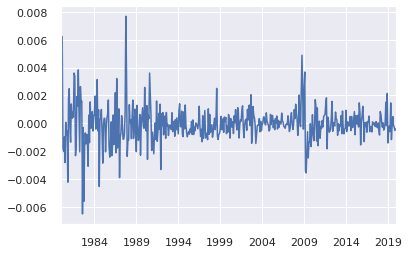

In [9]:
div_yield.plot()
plt.show()

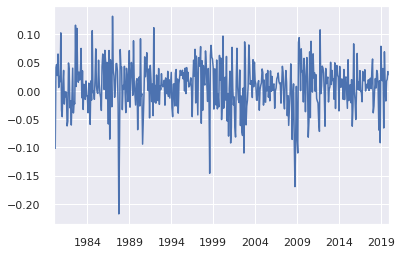

In [10]:
returns.plot()
plt.show()

## Modelling

In [19]:
series = div_yield

In [11]:
series = returns

### Try hmmlearn

In [12]:
from src.hmm import HMM

In [13]:
%%time
hmm = HMM(switch_var=True, k=2)
hmm = hmm.fit(series, package='hmmlearn', iter=100)

CPU times: user 312 ms, sys: 15.6 ms, total: 328 ms
Wall time: 173 ms


In [14]:
hmm.metrics_

llf     866.6840
aic   -1721.3681
bic   -1696.3253
dtype: float64

In [15]:
hmm.steady_state_

array([0.53517575, 0.46482425])

<AxesSubplot:>

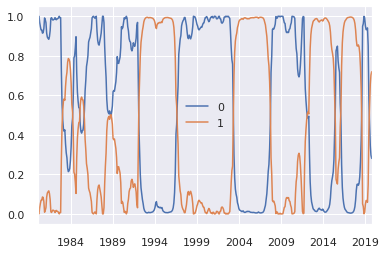

In [16]:
hmm.smooth_prob_.plot()

In [17]:
hmm.smooth_prob_.iloc[0]

0   1.0000
1   0.0000
Name: 1980-01-31 00:00:00, dtype: float64

In [18]:
hmm.get_mixture_distribution().components

[(0.005618249366904958, 0.05291549474669788, 0.5351757474532014),
 (0.011019782701146348, 0.02580663349843228, 0.46482425254679854)]

In [19]:
hmm.params_

p[0->0]     0.9641
p[1->0]     0.0413
const[0]    0.0056
const[1]    0.0110
sigma2[0]   0.0028
sigma2[1]   0.0007
dtype: float64

### statsmodels

In [20]:
%%time
hmm = HMM(switch_var=True, k=2)
hmm = hmm.fit(series, start_params=None, iter=100, package='statsmodels')

CPU times: user 406 ms, sys: 15.6 ms, total: 422 ms
Wall time: 521 ms


In [21]:
hmm.metrics_

llf     867.2589
aic   -1722.5179
bic   -1697.4752
dtype: float64

In [22]:
hmm.steady_state_

array([0.37812833, 0.62187167])

<AxesSubplot:>

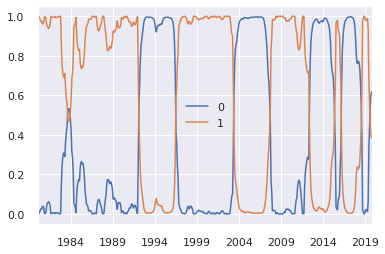

In [23]:
hmm.smooth_prob_.plot()

<AxesSubplot:>

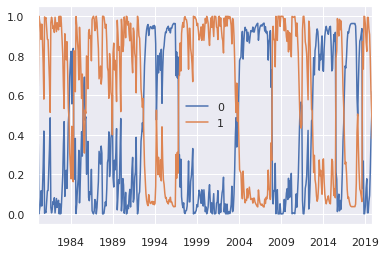

In [24]:
hmm.filt_prob_.plot()

In [25]:
hmm.smooth_prob_.iloc[0]

0   0.0306
1   0.9694
Name: 1980-01-31 00:00:00, dtype: float64

### Fit

In [26]:
# from src.hmm import HMM

# hmm = HMM(switch_var=True, k=4)
# hmm = hmm.fit(series, start_params=None, package='baumwelch')

../src/hmm.py:109: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if state == 'steady_state':
../src/hmm.py:111: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif state == 'latest':


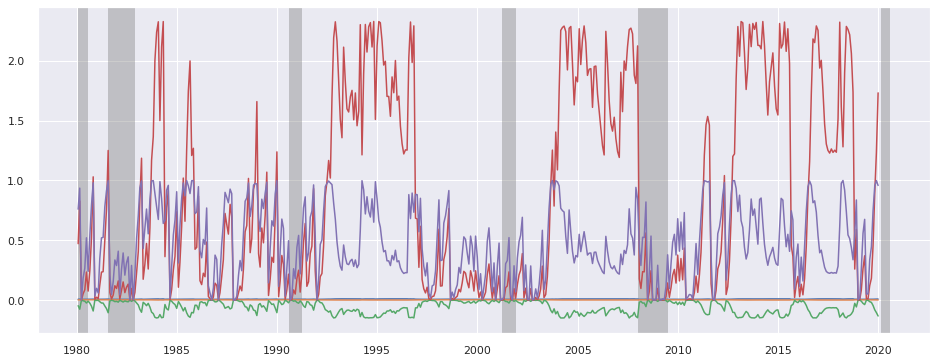

In [27]:
mom = hmm.filtered_moments()

fig, ax = plt.subplots(figsize=(16,6))
ax.plot(mom)
kf.add_recession_bars(ax, startdate=mom.index[0])
plt.show()

<AxesSubplot:>

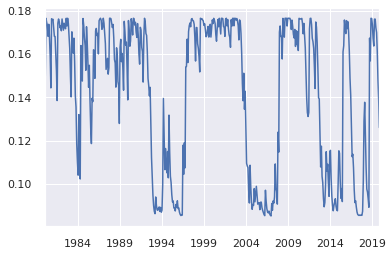

In [28]:
(mom['var']**0.5*np.sqrt(12)).plot()

../src/hmm.py:109: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if state == 'steady_state':
../src/hmm.py:111: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif state == 'latest':


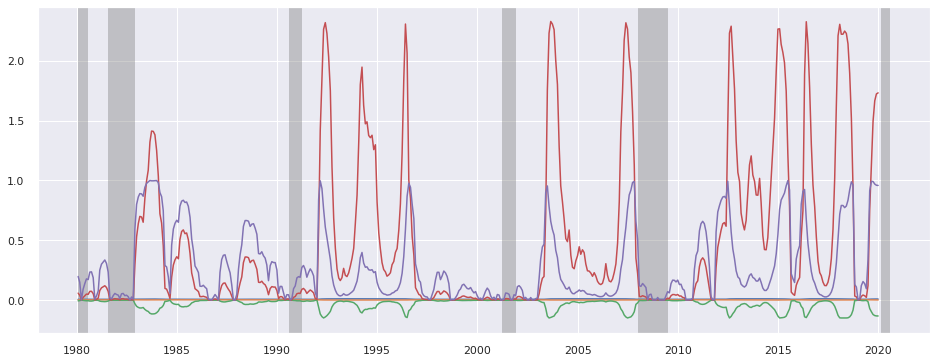

In [29]:
mom = hmm.smoothened_moments()

fig, ax = plt.subplots(figsize=(16,6))
ax.plot(mom)
kf.add_recession_bars(ax, startdate=mom.index[0])
plt.show()

<AxesSubplot:>

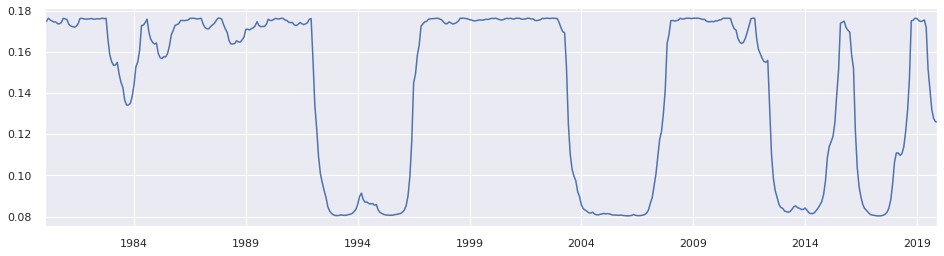

In [30]:
(mom['var']**0.5*np.sqrt(12)).plot(figsize=(16,4))

<AxesSubplot:>

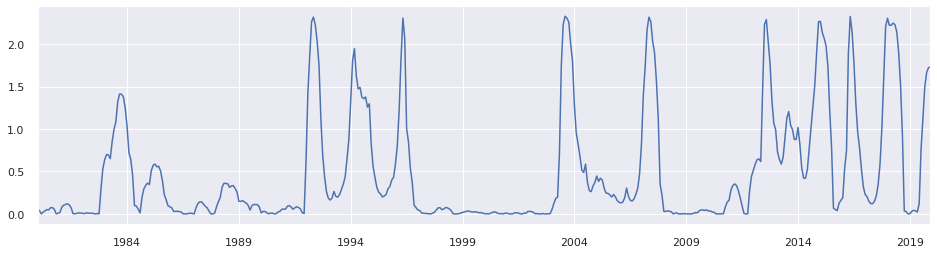

In [31]:
(mom['kurt']).plot(figsize=(16,4))

<AxesSubplot:>

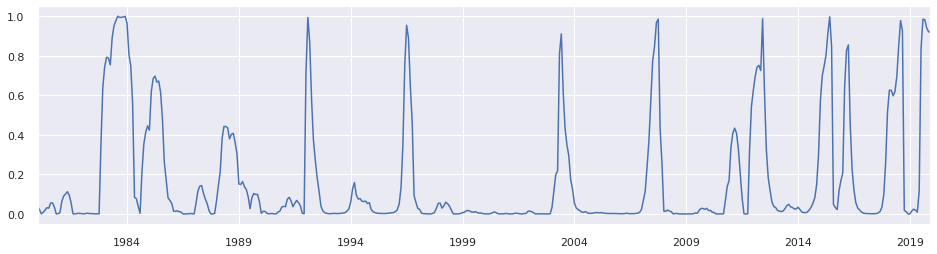

In [32]:
(mom['entropy']**2).plot(figsize=(16,4))

### Plot

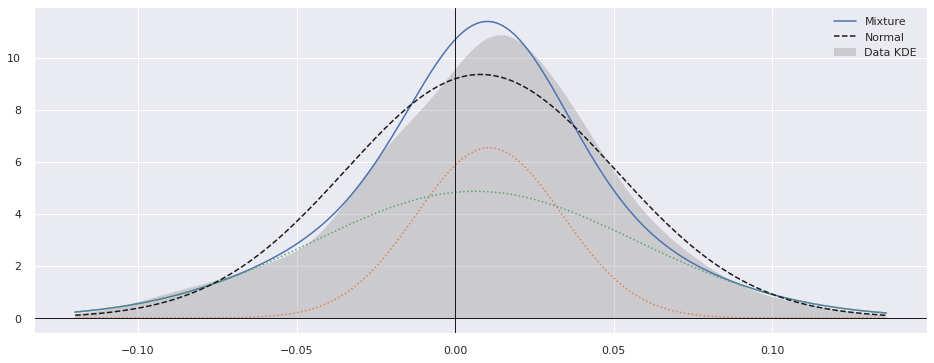

In [33]:
from src.plots import plot_mixture_pdf, plot_mixture_components, plot_kernel_density, plot_fitted_normal

mix = hmm.get_mixture_distribution(state='steady_state')

fig, ax = plt.subplots(1, 1, figsize=[16,6])

plot_mixture_pdf(mix, ax=ax, label='Mixture')
plot_mixture_components(mix, ax=ax)
plot_kernel_density(series, ax=ax, label='Data KDE', color='grey')
ax.axhline(0, color='k', linewidth=1)
ax.axvline(0, color='k', linewidth=1)
plot_fitted_normal(series, ax=ax, linestyle='--', color='k', label='Normal')
ax.legend()

plt.show()

In [34]:
mix.components

[(-0.01821192107045016, 0.022363252962660996, 0.18408634935905527),
 (0.020950714564851723, 0.023295901376933156, 0.5351213527136829),
 (0.07986389766044726, 0.02283080517284564, 0.05026956748099323),
 (-0.01701208484755535, 0.05842918131346118, 0.2305227304462687)]

In [35]:
hmm.transition_matrix_.round(2)

array([[0.02, 0.73, 0.07, 0.18],
       [0.34, 0.66, 0.  , 0.01],
       [0.  , 0.99, 0.  , 0.  ],
       [0.  , 0.  , 0.16, 0.84]])

In [50]:
%%time
fit_stats = pd.DataFrame(columns=['llf','aic','bic'])
for k in range(2,11):
    hmm = HMM(switch_var=True, k=k).fit(series)
    fit_stats = fit_stats.append(hmm.metrics_.rename(k))
fit_stats

/home/rubelrennfix/.virtualenvs/hmmdalah/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/rubelrennfix/.virtualenvs/hmmdalah/lib/python3.6/site-packages/statsmodels/base/model.py:1354: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/home/rubelrennfix/.virtualenvs/hmmdalah/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/rubelrennfix/.virtualenvs/hmmdalah/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/rubelrennfix/.virtualenvs/hmmdalah/lib/python3.6/site-packages/statsmodels/base/model.py:568: Conve

CPU times: user 12min 13s, sys: 43.3 s, total: 12min 56s
Wall time: 11min 29s


,llf,aic,bic
2,867.2589,-1722.5179,-1697.4752
3,875.4253,-1726.8506,-1676.7652
4,878.4724,-1716.9447,-1633.4690
5,884.1989,-1708.3977,-1583.1841
6,887.7165,-1691.4329,-1516.1339
7,884.1191,-1656.2382,-1422.5062
8,897.9796,-1651.9593,-1351.4467
9,900.9885,-1621.9770,-1246.3362
10,912.0602,-1604.1205,-1145.0040


<AxesSubplot:>

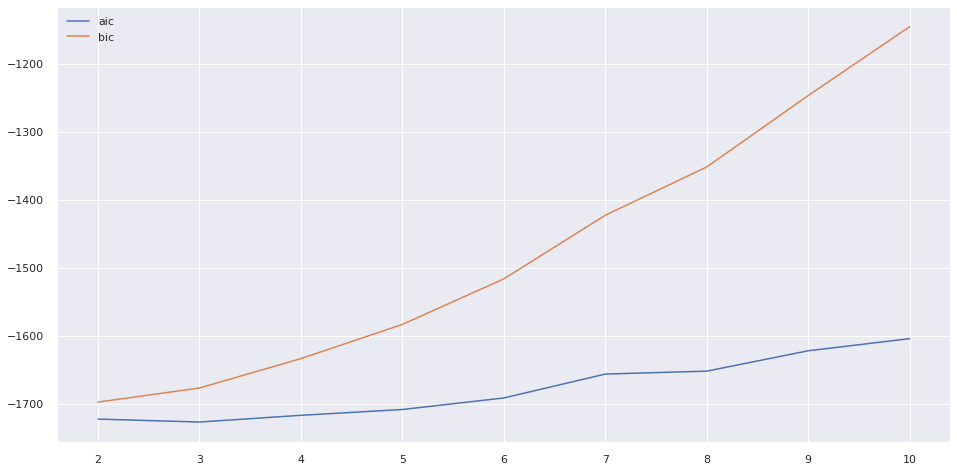

In [51]:
fit_stats[['aic','bic']].plot(figsize=[16,8])

<AxesSubplot:>

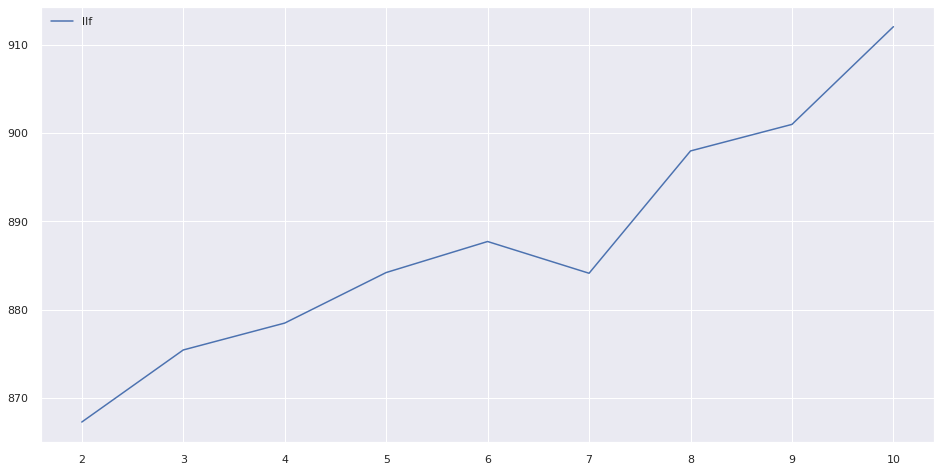

In [52]:
fit_stats[['llf']].plot(figsize=[16,8])

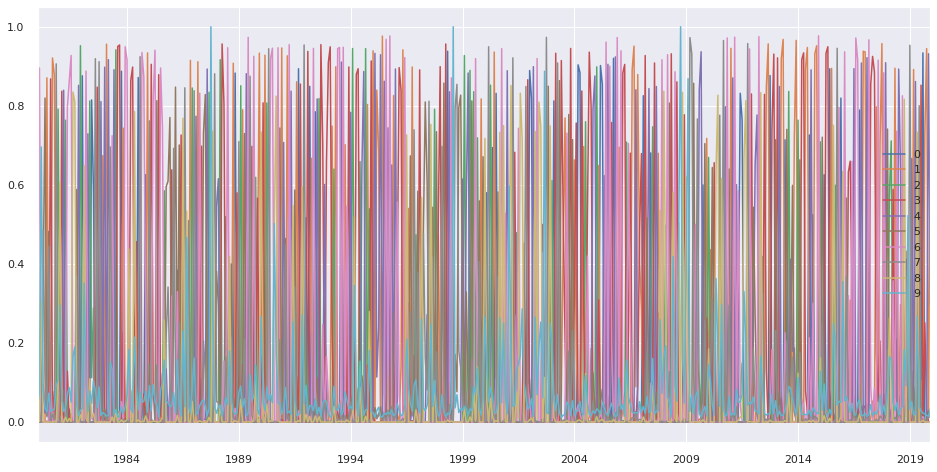

In [53]:
hmm.filt_prob_.plot(figsize=[16,8])
plt.show()

../src/model.py:85: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if state == 'steady_state':
../src/model.py:87: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif state == 'latest':


<AxesSubplot:>

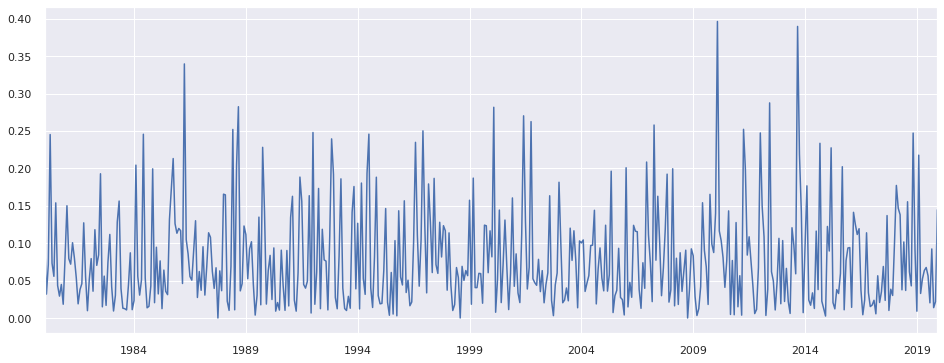

In [59]:
(hmm.filtered_moments()['entropy']**2).plot(figsize=(16,6))

In [146]:
from src.models import NormalModel

In [176]:
%%time
test = HMM()
test.start_probas = np.array([[0.4, 0.6]])
test.transition_matrix = np.array([[0.8, 0.2],[0.2, 0.8]])
test.emission_models = (NormalModel(mu=0, sigma=1), NormalModel(mu=-0.05, sigma=2))

test = test._estimate_baum_welch(np.array(series), max_iter=1000)

pd.Series(test.convergence_).plot()

CPU times: user 2.22 s, sys: 15.6 ms, total: 2.23 s
Wall time: 2.27 s


In [177]:
%%time
test = HMM()
test.start_probas = np.array([[0.4, 0.6]])
test.transition_matrix = np.array([[0.8, 0.2],[0.2, 0.8]])
test.emission_models = (NormalModel(mu=0, sigma=1), NormalModel(mu=-0.05, sigma=2))

#test = test._estimate_baum_welch(np.array(series), max_iter=1000)
test.fit(series, package='baumwelch', iter=100, start_params=None)

CPU times: user 1.42 s, sys: 31.2 ms, total: 1.45 s
Wall time: 1.45 s


../src/hmm.py:289: UserWarning: maximum number of iterations reached
  warnings.warn('maximum number of iterations reached')


In [167]:
test.transition_matrix

array([[0.96708063, 0.03291937],
       [0.02610126, 0.97389874]])

In [168]:
test.transition_matrix_

TypeError: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'

## Predictive Regressions

In [26]:
hmm = HMM(switch_var=True, k=2)
hmm = hmm.fit(div_yield, start_params=None, iter=100, package='statsmodels')
mom = hmm.filtered_moments()
#mom = hmm.smoothened_moments()

/home/rubelrennfix/.virtualenvs/hmmdalah/lib/python3.6/site-packages/statsmodels/base/model.py:1354: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
../src/hmm.py:109: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if state == 'steady_state':
../src/hmm.py:111: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif state == 'latest':


In [27]:
dta = kf.FinancialDataFrame(mom).astype(float)
dta['return'] = returns
dta['dp'] = div_yield
dta['std'] = dta['var']**.5
dta.head(5)

,mean,var,skew,kurt,entropy,return,dp,std
1980-01-31,-0.0001,0.0000,-0.0024,0.0417,0.1289,0.0576,-0.0024,0.0019
1980-02-29,-0.0001,0.0000,-0.0067,0.1199,0.2858,-0.0044,0.0007,0.0019
1980-03-31,-0.0001,0.0000,-0.0000,0.0000,0.0000,-0.1018,0.0062,0.0020
1980-04-30,-0.0001,0.0000,-0.0002,0.0032,0.0150,0.0411,-0.0018,0.0020
1980-05-31,-0.0001,0.0000,-0.0001,0.0016,0.0082,0.0466,-0.0020,0.0020


In [28]:
dta.corr()

,mean,var,skew,kurt,entropy,return,dp,std
mean,1.0000,-1.0000,-0.3180,0.4926,-0.2539,-0.0284,0.0589,-0.9974
var,-1.0000,1.0000,0.3177,-0.4924,0.2543,0.0284,-0.0588,0.9974
skew,-0.3180,0.3177,1.0000,-0.9454,-0.6175,0.0630,-0.0743,0.2585
kurt,0.4926,-0.4924,-0.9454,1.0000,0.3550,-0.0672,0.0740,-0.4487
entropy,-0.2539,0.2543,-0.6175,0.3550,1.0000,-0.0350,0.0528,0.3209
return,-0.0284,0.0284,0.0630,-0.0672,-0.0350,1.0000,-0.9104,0.0252
dp,0.0589,-0.0588,-0.0743,0.0740,0.0528,-0.9104,1.0000,-0.0541
std,-0.9974,0.9974,0.2585,-0.4487,0.3209,0.0252,-0.0541,1.0000


In [35]:
table = kf.RegressionTable()

l=1
endog = 'return'
add_outputs = ['N', 'R-squared']

table = table.join_regression(dta.fit_linear_regression(endog=endog, exog=['mean'], lag=l), add_outputs=add_outputs)
table = table.join_regression(dta.fit_linear_regression(endog=endog, exog=['var'], lag=l), add_outputs=add_outputs)
table = table.join_regression(dta.fit_linear_regression(endog=endog, exog=['skew'], lag=l), add_outputs=add_outputs)
table = table.join_regression(dta.fit_linear_regression(endog=endog, exog=['kurt'], lag=l), add_outputs=add_outputs)
table = table.join_regression(dta.fit_linear_regression(endog=endog, exog=['entropy'], lag=l), add_outputs=add_outputs)
table = table.join_regression(dta.fit_linear_regression(endog=endog, exog=['mean','var'], lag=l), add_outputs=add_outputs)
table = table.join_regression(dta.fit_linear_regression(endog=endog, exog=['skew','kurt'], lag=l), add_outputs=add_outputs)
table = table.join_regression(dta.fit_linear_regression(endog=endog, exog=['mean','var','entropy'], lag=l), add_outputs=add_outputs)
table = table.join_regression(dta.fit_linear_regression(endog=endog, exog=['skew','kurt','entropy'], lag=l), add_outputs=add_outputs)
table = table.change_variable_order(['const','mean','var','skew','kurt','entropy'])
table = table.change_descriptive_order(add_outputs)
table

(1)         (2)        (3)        (4)        (5)  \
const     coeff      0.0025      0.0042  0.0083***  0.0091***  0.0072***   
          t-stat   (0.6416)    (1.3902)   (3.2383)   (3.4869)   (2.9022)   
mean      coeff   -74.9474*                                                
          t-stat  (-1.6605)                                                
var       coeff              2197.3521*                                    
          t-stat               (1.6605)                                    
skew      coeff                             0.0141                         
          t-stat                          (0.2359)                         
kurt      coeff                                       -0.0011              
          t-stat                                    (-0.6927)              
entropy   coeff                                                   0.0035   
          t-stat                                                (0.5103)   
N                       479         479        479        479        479   
R-squared            0.0057      0.0057     0.0001     0.0010     0.0005   

                         (6)        (7)             (8)        (9)  
const     coeff       0.0327  0.0091***        -14.6991  0.0115***  
          t-stat    (0.0139)   (3.4656)       (-0.7108)   (3.2379)  
mean      coeff    1256.5638               -647755.8786             
          t-stat    (0.0121)                  (-0.7110)             
var       coeff   39037.9040             -18991219.1187             
          t-stat    (0.0129)                  (-0.7110)             
skew      coeff                 -0.2357                    -0.6824  
          t-stat              (-1.2862)                  (-1.4147)  
kurt      coeff                 -0.0073                    -0.0173  
          t-stat              (-1.4419)                  (-1.5443)  
entropy   coeff                                  0.0451    -0.0195  
          t-stat                               (0.7171)  (-1.0011)  
N                        479        479             479        479  
R-squared             0.0057     0.0045          0.0068     0.0066